In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
import numpy as np
import xml.etree.ElementTree as ET
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import keras
from google.colab.patches import cv2_imshow
from keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm
import numpy as np
import keras
import tensorflow as tf
from tensorflow.python.keras.models import Sequential,load_model,clone_model
from tensorflow.python.keras.layers import Convolution2D, Activation, MaxPooling2D, Dense, Flatten,Conv2D,Reshape,Dropout, Input
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.python.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD,Adam
import sys

dir_anno = "drive/My Drive/pascal-voc-2007/VOCtrainval/VOCdevkit/VOC2007/Annotations"
img_dir  = "drive/My Drive/pascal-voc-2007/VOCtrainval/VOCdevkit/VOC2007/JPEGImages"
dir_anno_test = "drive/My Drive/pascal-voc-2007/VOCtest/VOCdevkit/VOC2007/Annotations"
img_dir_test = "drive/My Drive/pascal-voc-2007/VOCtest/VOCdevkit/VOC2007/JPEGImages"

In [3]:
# Use df_anno.csv for annotations. This code takes a lot of time, do not rerun.
def extract_from_xml(tree):
    num_obj = 0
    row  = {}
    for el in tree.iter():
      if el.tag == "object":
        for elem in el:
          if elem.tag == "name": # Process name tags
            row["box_{}_{}".format(num_obj,elem.tag)] = str(elem.text)              
          if elem.tag == "bndbox": # Process bounding box tags
            for i in elem:
              row["box_{}_{}".format(num_obj,i.tag)] = float(i.text)
            num_obj += 1
      
      if el.tag == "size":
        for elem in el:
          row[elem.tag] = int(elem.text)

    row["num_obj"] = num_obj
    return row

In [4]:
cols = ['width','height','depth','num_obj']
for i in range(42):
  d =[]
  for j in ['name','xmin','ymin','xmax','ymax']:
    d.append(f'box_{i}_{j}')
  cols.extend(d)

In [ ]:
df_anno = pd.DataFrame(columns=cols)
from tqdm.notebook import tqdm

for data in tqdm(os.listdir(dir_anno)):
  tree = ET.parse(os.path.join(dir_anno,data))
  row = extract_from_xml(tree)
  row["fileID"] = data
  df_anno = df_anno.append(row,ignore_index=True)

!mkdir drive/MyDrive/SPPnet/
df_anno.to_csv(os.path.join("drive/MyDrive/SPPnet","df_anno.csv"),index=False) # Save dataframe as csv file

In [ ]:
# Loading test data annotations
df_anno_test = pd.DataFrame(columns=cols)

for data in tqdm(os.listdir(dir_anno_test)):
  tree = ET.parse(os.path.join(dir_anno_test,data))
  row = extract_from_xml(tree)
  row["fileID"] = data
  df_anno_test = df_anno_test.append(row,ignore_index=True)
  # break

In [ ]:
df_anno_test.to_csv(os.path.join("drive/MyDrive/SPPnet","df_anno_test.csv"),index=False) # Save dataframe as csv file

In [ ]:
# Loading training annotation data from csv file. temp code
df_anno = pd.read_csv("drive/My Drive/SPPnet/df_anno.csv")
df_anno.head()
df_anno.fillna('unknown',inplace=True)
max_num_obj = max(df_anno.num_obj)
# df_anno = df_anno[col]
df_anno.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (189,194,199,204,209) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,width,height,depth,num_obj,box_0_name,box_0_xmin,box_0_ymin,box_0_xmax,box_0_ymax,box_1_name,box_1_xmin,box_1_ymin,box_1_xmax,box_1_ymax,box_2_name,box_2_xmin,box_2_ymin,box_2_xmax,box_2_ymax,box_3_name,box_3_xmin,box_3_ymin,box_3_xmax,box_3_ymax,box_4_name,box_4_xmin,box_4_ymin,box_4_xmax,box_4_ymax,box_5_name,box_5_xmin,box_5_ymin,box_5_xmax,box_5_ymax,box_6_name,box_6_xmin,box_6_ymin,box_6_xmax,box_6_ymax,box_7_name,...,box_34_xmin,box_34_ymin,box_34_xmax,box_34_ymax,box_35_name,box_35_xmin,box_35_ymin,box_35_xmax,box_35_ymax,box_36_name,box_36_xmin,box_36_ymin,box_36_xmax,box_36_ymax,box_37_name,box_37_xmin,box_37_ymin,box_37_xmax,box_37_ymax,box_38_name,box_38_xmin,box_38_ymin,box_38_xmax,box_38_ymax,box_39_name,box_39_xmin,box_39_ymin,box_39_xmax,box_39_ymax,box_40_name,box_40_xmin,box_40_ymin,box_40_xmax,box_40_ymax,box_41_name,box_41_xmin,box_41_ymin,box_41_xmax,box_41_ymax,fileID
0,500,375,3,6,person,285.0,291.0,304.0,337.0,person,263,293,284,335,car,457,230,500,248,car,1,322,80,375,car,1,338,38,375,train,1,200,470,334,unknown,unknown,unknown,unknown,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,007963.xml
1,500,334,3,1,dog,28.0,111.0,380.0,212.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,007954.xml
2,500,375,3,3,pottedplant,362.0,133.0,460.0,307.0,pottedplant,107,128,163,227,diningtable,2,167,500,375,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,007956.xml
3,500,375,3,3,car,101.0,146.0,326.0,299.0,car,296,163,500,248,person,224,142,263,184,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,007970.xml
4,500,333,3,2,person,174.0,120.0,256.0,171.0,car,52,118,407,245,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,007964.xml


In [ ]:
# Loading test annotations data from csv file. temp code
df_anno_test = pd.read_csv("drive/My Drive/SPPnet/df_anno_test.csv")
df_anno_test.fillna('unknown',inplace=True)
df_anno_test.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (164,169,174,179,184,189,194,199,204) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,width,height,depth,num_obj,box_0_name,box_0_xmin,box_0_ymin,box_0_xmax,box_0_ymax,box_1_name,box_1_xmin,box_1_ymin,box_1_xmax,box_1_ymax,box_2_name,box_2_xmin,box_2_ymin,box_2_xmax,box_2_ymax,box_3_name,box_3_xmin,box_3_ymin,box_3_xmax,box_3_ymax,box_4_name,box_4_xmin,box_4_ymin,box_4_xmax,box_4_ymax,box_5_name,box_5_xmin,box_5_ymin,box_5_xmax,box_5_ymax,box_6_name,box_6_xmin,box_6_ymin,box_6_xmax,box_6_ymax,box_7_name,...,box_34_xmin,box_34_ymin,box_34_xmax,box_34_ymax,box_35_name,box_35_xmin,box_35_ymin,box_35_xmax,box_35_ymax,box_36_name,box_36_xmin,box_36_ymin,box_36_xmax,box_36_ymax,box_37_name,box_37_xmin,box_37_ymin,box_37_xmax,box_37_ymax,box_38_name,box_38_xmin,box_38_ymin,box_38_xmax,box_38_ymax,box_39_name,box_39_xmin,box_39_ymin,box_39_xmax,box_39_ymax,box_40_name,box_40_xmin,box_40_ymin,box_40_xmax,box_40_ymax,box_41_name,box_41_xmin,box_41_ymin,box_41_xmax,box_41_ymax,fileID
0,500,333,3,1,person,106.0,96.0,377.0,332.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,007981.xml
1,500,375,3,3,car,193.0,52.0,326.0,120.0,car,402,68,476,116,person,63,15,124,201,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,007967.xml
2,500,322,3,1,aeroplane,35.0,115.0,393.0,207.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,007973.xml
3,500,307,3,4,person,303.0,34.0,406.0,143.0,person,107,60,210,151,horse,226,49,472,253,horse,4,61,288,275,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,007972.xml
4,500,281,3,4,tvmonitor,89.0,141.0,166.0,189.0,tvmonitor,1,138,135,272,tvmonitor,86,149,331,240,tvmonitor,1,217,452,281,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,007982.xml


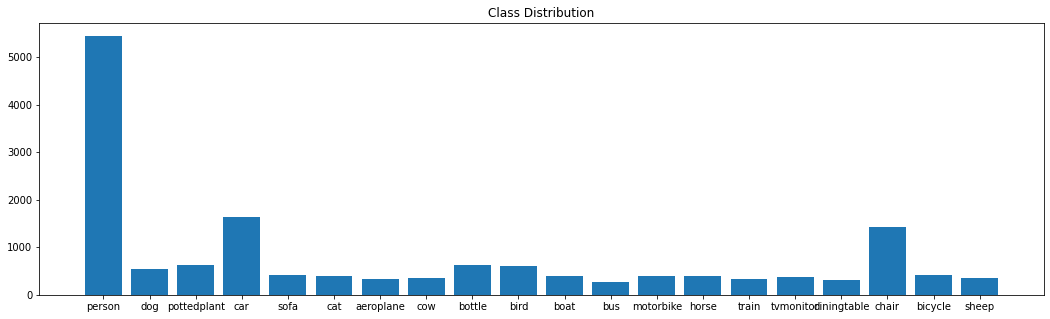

In [ ]:
# Plot bar gragh and initiate directories

counter_obj = []
for i in range(0,max_num_obj):
    counter_obj.extend(df_anno["box_{}_name".format(i)].values)

counter_obj = np.asarray(counter_obj)

count = Counter(counter_obj[counter_obj != 'unknown']) # Count occurences of a class excluding NaN values
# print(count)

dict_y = {i:0 for i in list(count.keys())} # Identify the 20 classes of object that are present

# Plot the class distribution. Observe the data is quite unbalanced
xs = range(len(count.values()))
plt.figure(figsize = (18,5))
plt.bar(xs,count.values())
plt.xticks(xs,count.keys())
plt.title("Class Distribution")
plt.show()

In [ ]:
# Loading images
list_of_img_name = os.listdir(img_dir)
list_of_img_name_test = os.listdir(img_dir_test)

len(list_of_img_name), len(list_of_img_name_test)

(5017, 4973)

In [ ]:
# Image Variables

min_ref = 256
crop_dim = 224
schannel = 3

In [ ]:
from tqdm.notebook import tqdm
import gc
gc.collect()

def read_images(df, list_, img_dir):
  ''' This method reads the images from the list of image names and maps them with objects present in that image
      and returns the input variable (X) & output variable (y).
      Open CV is used to read, resize and interpolate the images.
      As the images are shrinked, INTER_AREA interpolation technique has been used.

    # Input
        list of image names
    # Output
        X,y
    # Output shape : 
        X : (no. of eg, height, width, no. of channels = 3)
        y : (no. of eg, no. of object classes = 20)
  '''

  X = [] # Input Variable
  y = [] # Output Variable
  count= 0
  
  for img in tqdm(list_):
    im = cv2.imread(os.path.join(img_dir,img))
    im_height, im_width, _ = im.shape

    aspect_ratio = im_height/im_width # Keep the aspect ratio same

    if im_height < im_width:
      im_height = min_ref
      im_width = int(min_ref/aspect_ratio)
    else:
      im_width = min_ref
      im_height = int(min_ref*aspect_ratio)
    
    im = cv2.resize(im,(im_width,im_height))
    # return im
    h, w, _ = im.shape
    im = im[int(h/2-crop_dim/2):int(h/2+crop_dim/2) , int(w/2-crop_dim/2):int(w/2+crop_dim/2)] # Crop the middle view

    dict_y1 = dict_y.copy()
    
    fileID = str(img.split(".")[0]) + ".xml"
    
    for i in range(4,210,5):
      try:
        k = fileID.split(".")[0].split(" ")[0]
        # print(k)
        index_val = df[df.fileID == fileID].to_numpy()[0][i]
      except:
        try:
          index_val = df[df.fileID.str.startswith(k)].to_numpy()[0][i]
        except:
          # continue
          print(fileID,k,i)
          break
      
      if index_val == "unknown":
        break

      dict_y1[index_val] = 1
    

    assert len(list(dict_y1.values())) == 20 ,print(dict_y1)
    # assert sum(dict_y1.values()) != 0 ,"Output length vector is not of correct size"
    if sum(dict_y1.values()) > 0:
      X.append(im)
      y.append(np.array(list(dict_y1.values())))
  
  return np.asarray(X),np.asarray(y)

In [ ]:
X,y = read_images(df_anno, list_of_img_name, img_dir) # Read training inputs and labels
X_test, y_test = read_images(df_anno_test, list_of_img_name_test, img_dir_test)

In [ ]:
X.shape,y.shape,X_test.shape,y_test.shape

In [ ]:
np.save("/content/drive/MyDrive/SPPnet/X.npy",X)
np.save("/content/drive/MyDrive/SPPnet/y.npy",y)
np.save("/content/drive/MyDrive/SPPnet/X_test.npy",X_test)
np.save("/content/drive/MyDrive/SPPnet/y_test.npy",y_test)